Train dataset length: 8000
Validation dataset length: 1000
Test dataset length: 1000


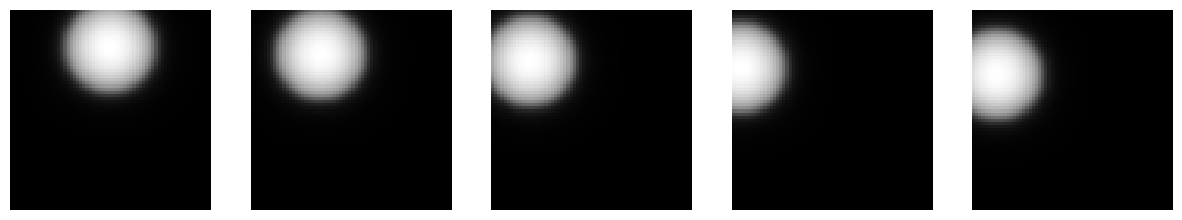

torch.Size([256, 1, 64, 64])


In [10]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import matplotlib.pyplot as plt

class CustomDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')], key=lambda x: int(x.split('_')[1].split('.')[0]))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_name).convert('L')  # Convert image to grayscale
        if self.transform:
            image = self.transform(image)
        return image

# Define the directory where images are stored
image_dir = 'images_10000'

# Define transformations (if any)
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create the dataset
dataset = CustomDataset(image_dir=image_dir, transform=transform)

# Calculate lengths for train, val, test datasets
total_len = len(dataset)
train_len = int(0.8 * total_len)
val_len = int(0.1 * total_len)
test_len = total_len - train_len - val_len

# Create subsets manually by indices
train_indices = list(range(0, train_len))
val_indices = list(range(train_len, train_len + val_len))
test_indices = list(range(train_len + val_len, total_len))

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Print the lengths of each dataset
print(f'Train dataset length: {len(train_dataset)}')
print(f'Validation dataset length: {len(val_dataset)}')
print(f'Test dataset length: {len(test_dataset)}')

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Function to display images
def show_images(images, nrow=1, ncol=5):
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 3))
    for i in range(ncol):
        ax = axes[i]
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()

# Display the first five images in the dataset
if __name__ == '__main__':
    # Display the first five images
    first_five_images = [dataset[i] for i in range(5)]
    show_images(first_five_images)
    
    # Example usage of data loaders
    for images in train_loader:
        print(images.size())  # Example output: torch.Size([64, 1, H, W])
        break

In [11]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # (B, 1, 64, 64) -> (B, 16, 32, 32)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # (B, 16, 32, 32) -> (B, 32, 16, 16)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (B, 32, 16, 16) -> (B, 64, 8, 8)
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 32)  # (B, 64*8*8) -> (B, 32)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64 * 8 * 8),  # (B, 32) -> (B, 64*8*8)
            nn.Unflatten(1, (64, 8, 8)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 64, 8, 8) -> (B, 32, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 32, 16, 16) -> (B, 16, 32, 32)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 16, 32, 32) -> (B, 1, 64, 64)
            nn.Sigmoid()  # Ensure the output values are between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
# Instantiate the model
model = Autoencoder()

# Create a sample input tensor with shape (B, 1, 64, 64), where B is the batch size
sample_input = torch.randn(32, 1, 64, 64)  # Using batch size of 1 for simplicity

# Pass the sample input through the model
output = model(sample_input)

# Print the output size
print(f"Output size: {output.size()}")

Output size: torch.Size([32, 1, 64, 64])


Using device: cuda
Epoch [1/1000], Train Loss: 0.1665, Val Loss: 0.0826
Validation loss decreased (inf --> 0.082580).  Saving model ...
Epoch [2/1000], Train Loss: 0.0811, Val Loss: 0.0806
Validation loss decreased (0.082580 --> 0.080558).  Saving model ...
Epoch [3/1000], Train Loss: 0.0804, Val Loss: 0.0803
Validation loss decreased (0.080558 --> 0.080254).  Saving model ...
Epoch [4/1000], Train Loss: 0.0789, Val Loss: 0.0668
Validation loss decreased (0.080254 --> 0.066754).  Saving model ...
Epoch [5/1000], Train Loss: 0.0307, Val Loss: 0.0109
Validation loss decreased (0.066754 --> 0.010930).  Saving model ...
Epoch [6/1000], Train Loss: 0.0050, Val Loss: 0.0025
Validation loss decreased (0.010930 --> 0.002466).  Saving model ...
Epoch [7/1000], Train Loss: 0.0018, Val Loss: 0.0013
Validation loss decreased (0.002466 --> 0.001333).  Saving model ...
Epoch [8/1000], Train Loss: 0.0012, Val Loss: 0.0010
Validation loss decreased (0.001333 --> 0.000989).  Saving model ...
Epoch [9/1

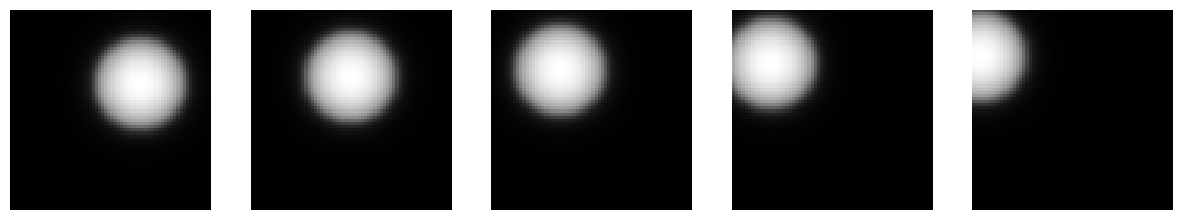

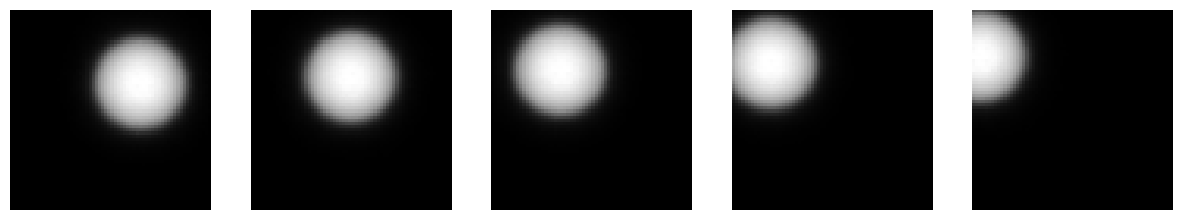

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Using device: {device}')

# Initialize the autoencoder, loss function and optimizer
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=20, verbose=False, delta=0, encoder_path='best_encoder_1_32.pth', decoder_path='best_decoder_1_32.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.encoder_path = encoder_path
        self.decoder_path = decoder_path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.encoder.state_dict(), self.encoder_path)
        torch.save(model.decoder.state_dict(), self.decoder_path)
        self.val_loss_min = val_loss

# Function to save the model
def save_model(model, encoder_path, decoder_path):
    torch.save(model.encoder.state_dict(), encoder_path)
    torch.save(model.decoder.state_dict(), decoder_path)

# Training function with early stopping
def train_autoencoder(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, patience=20):
    early_stopping = EarlyStopping(patience=patience, verbose=True, encoder_path='best_encoder_1_32.pth', decoder_path='best_decoder_1_32.pth')
    model.train()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images in train_loader:
            images = images.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)

        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images in val_loader:
                images = images.to(device)
                outputs = model(images)
                loss = criterion(outputs, images)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        # Adjust learning rate based on validation loss
        scheduler.step(avg_val_loss)

        # Check early stopping condition
        early_stopping(avg_val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Load the best model
    model.encoder.load_state_dict(torch.load('best_encoder_1_32.pth'))
    model.decoder.load_state_dict(torch.load('best_decoder_1_32.pth'))
    
    # Print the best validation loss
    print(f'Best Validation Loss: {early_stopping.val_loss_min:.4f}')
    
    return model

# Evaluation function
def evaluate_autoencoder(model, dataloader):
    model.eval()
    original_images = []
    reconstructed_images = []
    with torch.no_grad():
        for images in dataloader:
            images = images.to(device)
            outputs = model(images)
            original_images.extend(images.cpu())
            reconstructed_images.extend(outputs.cpu())
            break  # Remove this line if you want to evaluate the whole dataset
    return original_images, reconstructed_images

# Assume train_loader, val_loader, and test_loader are defined and loaded elsewhere

# Train the autoencoder with early stopping
autoencoder = train_autoencoder(autoencoder, train_loader, val_loader, criterion, optimizer, scheduler, epochs=1000, patience=20)

# Evaluate the autoencoder
original_images, reconstructed_images = evaluate_autoencoder(autoencoder, test_loader)

# Function to display images (assumed to be defined elsewhere in your code)
# def show_images(images, nrow, ncol):
#     # Display code here

# Display original and reconstructed images
show_images([original_images[i] for i in range(5)], nrow=1, ncol=5)
show_images([reconstructed_images[i] for i in range(5)], nrow=1, ncol=5)

In [13]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # (B, 1, 64, 64) -> (B, 16, 32, 32)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # (B, 16, 32, 32) -> (B, 32, 16, 16)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (B, 32, 16, 16) -> (B, 64, 8, 8)
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128)  # (B, 64*8*8) -> (B, 128)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(128, 64 * 8 * 8),  # (B, 128) -> (B, 64*8*8)
            nn.Unflatten(1, (64, 8, 8)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 64, 8, 8) -> (B, 32, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 32, 16, 16) -> (B, 16, 32, 32)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 16, 32, 32) -> (B, 1, 64, 64)
            nn.Sigmoid()  # Ensure the output values are between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
# Instantiate the model
model = Autoencoder()

# Create a sample input tensor with shape (B, 1, 64, 64), where B is the batch size
sample_input = torch.randn(32, 1, 64, 64)  # Using batch size of 1 for simplicity

# Pass the sample input through the model
output = model(sample_input)

# Print the output size
print(f"Output size: {output.size()}")

Output size: torch.Size([32, 1, 64, 64])


Using device: cuda
Epoch [1/1000], Train Loss: 0.1673, Val Loss: 0.1657
Validation loss decreased (inf --> 0.165681).  Saving model ...
Epoch [2/1000], Train Loss: 0.1562, Val Loss: 0.1384
Validation loss decreased (0.165681 --> 0.138402).  Saving model ...
Epoch [3/1000], Train Loss: 0.1206, Val Loss: 0.1025
Validation loss decreased (0.138402 --> 0.102482).  Saving model ...
Epoch [4/1000], Train Loss: 0.0845, Val Loss: 0.0763
Validation loss decreased (0.102482 --> 0.076274).  Saving model ...
Epoch [5/1000], Train Loss: 0.0745, Val Loss: 0.0731
Validation loss decreased (0.076274 --> 0.073061).  Saving model ...
Epoch [6/1000], Train Loss: 0.0718, Val Loss: 0.0701
Validation loss decreased (0.073061 --> 0.070081).  Saving model ...
Epoch [7/1000], Train Loss: 0.0646, Val Loss: 0.0529
Validation loss decreased (0.070081 --> 0.052932).  Saving model ...
Epoch [8/1000], Train Loss: 0.0369, Val Loss: 0.0220
Validation loss decreased (0.052932 --> 0.022028).  Saving model ...
Epoch [9/1

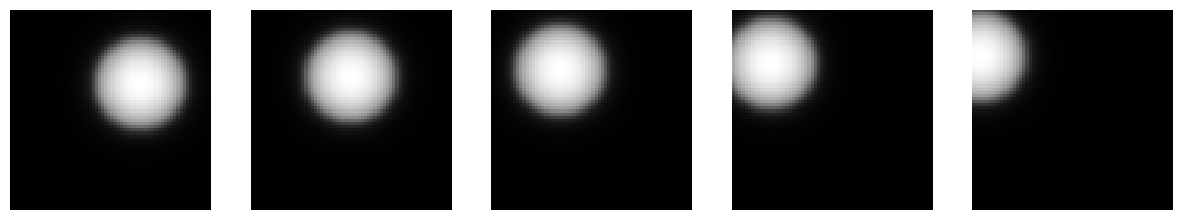

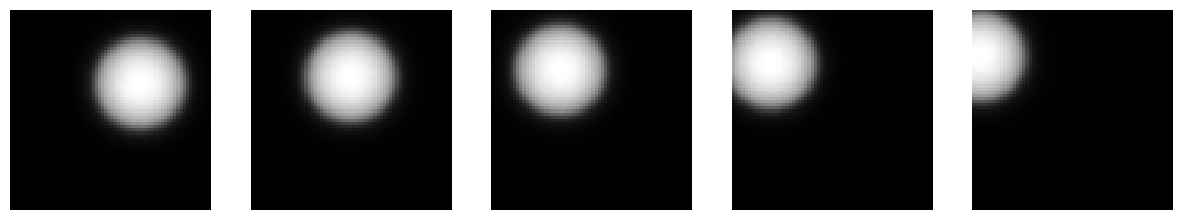

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Using device: {device}')

# Initialize the autoencoder, loss function and optimizer
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=20, verbose=False, delta=0, encoder_path='best_encoder_1_128.pth', decoder_path='best_encoder_1_128.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.encoder_path = encoder_path
        self.decoder_path = decoder_path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.encoder.state_dict(), self.encoder_path)
        torch.save(model.decoder.state_dict(), self.decoder_path)
        self.val_loss_min = val_loss

# Function to save the model
def save_model(model, encoder_path, decoder_path):
    torch.save(model.encoder.state_dict(), encoder_path)
    torch.save(model.decoder.state_dict(), decoder_path)

# Training function with early stopping
def train_autoencoder(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, patience=20):
    early_stopping = EarlyStopping(patience=patience, verbose=True, encoder_path='best_encoder_1_128.pth', decoder_path='best_decoder_1_128.pth')
    model.train()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images in train_loader:
            images = images.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)

        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images in val_loader:
                images = images.to(device)
                outputs = model(images)
                loss = criterion(outputs, images)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        # Adjust learning rate based on validation loss
        scheduler.step(avg_val_loss)

        # Check early stopping condition
        early_stopping(avg_val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Load the best model
    model.encoder.load_state_dict(torch.load('best_encoder_1_128.pth'))
    model.decoder.load_state_dict(torch.load('best_decoder_1_128.pth'))
    
    # Print the best validation loss
    print(f'Best Validation Loss: {early_stopping.val_loss_min:.4f}')
    
    return model

# Evaluation function
def evaluate_autoencoder(model, dataloader):
    model.eval()
    original_images = []
    reconstructed_images = []
    with torch.no_grad():
        for images in dataloader:
            images = images.to(device)
            outputs = model(images)
            original_images.extend(images.cpu())
            reconstructed_images.extend(outputs.cpu())
            break  # Remove this line if you want to evaluate the whole dataset
    return original_images, reconstructed_images

# Assume train_loader, val_loader, and test_loader are defined and loaded elsewhere

# Train the autoencoder with early stopping
autoencoder = train_autoencoder(autoencoder, train_loader, val_loader, criterion, optimizer, scheduler, epochs=1000, patience=20)

# Evaluate the autoencoder
original_images, reconstructed_images = evaluate_autoencoder(autoencoder, test_loader)

# Function to display images (assumed to be defined elsewhere in your code)
# def show_images(images, nrow, ncol):
#     # Display code here

# Display original and reconstructed images
show_images([original_images[i] for i in range(5)], nrow=1, ncol=5)
show_images([reconstructed_images[i] for i in range(5)], nrow=1, ncol=5)

In [1]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # (B, 1, 64, 64) -> (B, 16, 32, 32)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # (B, 16, 32, 32) -> (B, 32, 16, 16)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (B, 32, 16, 16) -> (B, 64, 8, 8)
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 512)  # (B, 64*8*8) -> (B, 512)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(512, 64 * 8 * 8),  # (B, 512) -> (B, 64*8*8)
            nn.Unflatten(1, (64, 8, 8)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 64, 8, 8) -> (B, 32, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 32, 16, 16) -> (B, 16, 32, 32)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 16, 32, 32) -> (B, 1, 64, 64)
            nn.Sigmoid()  # Ensure the output values are between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
# Instantiate the model
model = Autoencoder()

# Create a sample input tensor with shape (B, 1, 64, 64), where B is the batch size
sample_input = torch.randn(32, 1, 64, 64)  # Using batch size of 1 for simplicity

# Pass the sample input through the model
output = model(sample_input)

# Print the output size
print(f"Output size: {output.size()}")

Output size: torch.Size([32, 1, 64, 64])


Using device: cuda
Epoch [1/10000], Train Loss: 0.2591, Val Loss: 0.2583
Validation loss decreased (inf --> 0.258290).  Saving model ...
Epoch [2/10000], Train Loss: 0.2567, Val Loss: 0.2529
Validation loss decreased (0.258290 --> 0.252857).  Saving model ...
Epoch [3/10000], Train Loss: 0.2406, Val Loss: 0.2180
Validation loss decreased (0.252857 --> 0.217959).  Saving model ...
Epoch [4/10000], Train Loss: 0.1890, Val Loss: 0.1509
Validation loss decreased (0.217959 --> 0.150944).  Saving model ...
Epoch [5/10000], Train Loss: 0.1214, Val Loss: 0.0948
Validation loss decreased (0.150944 --> 0.094848).  Saving model ...
Epoch [6/10000], Train Loss: 0.0875, Val Loss: 0.0795
Validation loss decreased (0.094848 --> 0.079535).  Saving model ...
Epoch [7/10000], Train Loss: 0.0790, Val Loss: 0.0781
Validation loss decreased (0.079535 --> 0.078094).  Saving model ...
Epoch [8/10000], Train Loss: 0.0773, Val Loss: 0.0765
Validation loss decreased (0.078094 --> 0.076479).  Saving model ...
Ep

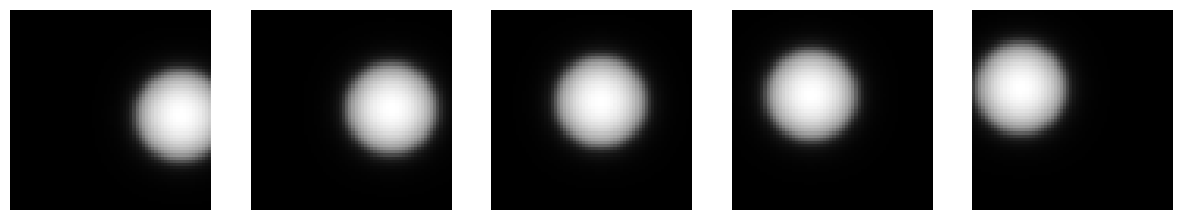

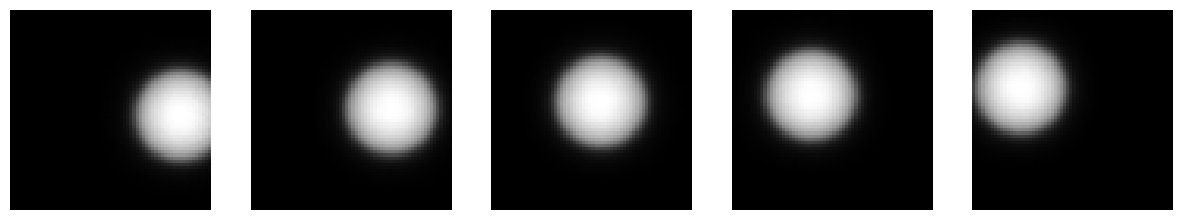

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Using device: {device}')

# Initialize the autoencoder, loss function and optimizer
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=20, verbose=False, delta=0, encoder_path='best_encoder_1.pth', decoder_path='best_decoder_1.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.encoder_path = encoder_path
        self.decoder_path = decoder_path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.encoder.state_dict(), self.encoder_path)
        torch.save(model.decoder.state_dict(), self.decoder_path)
        self.val_loss_min = val_loss

# Function to save the model
def save_model(model, encoder_path, decoder_path):
    torch.save(model.encoder.state_dict(), encoder_path)
    torch.save(model.decoder.state_dict(), decoder_path)

# Training function with early stopping
def train_autoencoder(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, patience=20):
    early_stopping = EarlyStopping(patience=patience, verbose=True, encoder_path='best_encoder_1.pth', decoder_path='best_decoder_1.pth')
    model.train()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images in train_loader:
            images = images.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)

        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images in val_loader:
                images = images.to(device)
                outputs = model(images)
                loss = criterion(outputs, images)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        # Adjust learning rate based on validation loss
        scheduler.step(avg_val_loss)

        # Check early stopping condition
        early_stopping(avg_val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Load the best model
    model.encoder.load_state_dict(torch.load('best_encoder_1.pth'))
    model.decoder.load_state_dict(torch.load('best_decoder_1.pth'))
    
    # Print the best validation loss
    print(f'Best Validation Loss: {early_stopping.val_loss_min:.4f}')
    
    return model

# Evaluation function
def evaluate_autoencoder(model, dataloader):
    model.eval()
    original_images = []
    reconstructed_images = []
    with torch.no_grad():
        for images in dataloader:
            images = images.to(device)
            outputs = model(images)
            original_images.extend(images.cpu())
            reconstructed_images.extend(outputs.cpu())
            break  # Remove this line if you want to evaluate the whole dataset
    return original_images, reconstructed_images

# Assume train_loader, val_loader, and test_loader are defined and loaded elsewhere

# Train the autoencoder with early stopping
autoencoder = train_autoencoder(autoencoder, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10000, patience=20)

# Evaluate the autoencoder
original_images, reconstructed_images = evaluate_autoencoder(autoencoder, test_loader)

# Function to display images (assumed to be defined elsewhere in your code)
# def show_images(images, nrow, ncol):
#     # Display code here

# Display original and reconstructed images
show_images([original_images[i] for i in range(5)], nrow=1, ncol=5)
show_images([reconstructed_images[i] for i in range(5)], nrow=1, ncol=5)